# Chinook Database Analysis

This project explores the public Chinook sample database, which simulates a digital media store.
I analyze sales trends, employee performance, and customer behavior using SQL queries combined with Python for data processing and visualization.
The goal is to create insightful dashboards in Tableau and make predictive analysis based on these initial findings.

**Dataset**: Chinook SQLITE databse (chinook.db)
**Tools used**: SQLite, Python (pandas, matplotlib, seaborn) Tableau

In [2]:
import os
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

conn = sqlite3.connect('../data/chinook.db')

print("Connected to the database successfully.")

def run_query(query):
    return pd.read_sql_query(query, conn)


Connected to the database successfully.


## Data Extraction

We'll start by querying a few key insights from the database: 

- Top 10 customers by total spent
- Employees who manage the most customers
- Average revenue trends by day of the week

### Top 10 customers by total spent

The following query finds the 10 highest-spending customers.

In [9]:
top_ten_customers_query = """
SELECT  invoice.customer_id, 
        customer.first_name || ' ' || customer.last_name AS customer_name, 
        customer.country,
        SUM(invoice.total) AS total_spent
FROM invoice
JOIN customer ON invoice.customer_id = customer.customer_id
GROUP BY invoice.customer_id, customer.first_name, customer.last_name, customer.country
ORDER BY total_spent DESC
Limit 10;
"""
top_ten_customers = run_query(top_ten_customers_query)
top_ten_customers.head()

,customer_id,customer_name,country,total_spent
0,5,František Wichterlová,Czech Republic,144.54
1,6,Helena Holý,Czech Republic,128.70
2,46,Hugh O'Reilly,Ireland,114.84
3,58,Manoj Pareek,India,111.87
4,1,Luís Gonçalves,Brazil,108.90


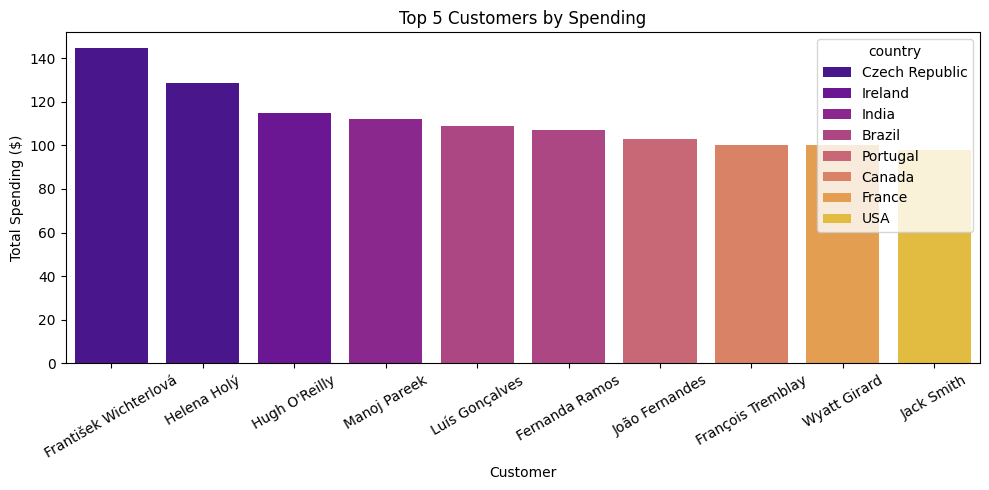

In [13]:
plt.figure(figsize=(10,5))
sns.barplot(data=top_ten_customers, x='customer_name', y='total_spent', palette='plasma', hue='country')
plt.title('Top 5 Customers by Spending')
plt.ylabel('Total Spending ($)')
plt.xlabel('Customer')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

### Employee Performance Analysis

Find and sort employees by their customer count.

In [21]:
employee_performance_query = """
SELECT employee.employee_id, 
       employee.first_name || ' ' || employee.last_name AS employee_name, 
       COUNT(customer.customer_id) AS num_customers
FROM employee
JOIN customer ON employee.employee_id = customer.support_rep_id
GROUP BY employee.employee_id, employee.first_name, employee.last_name
ORDER BY num_customers DESC;
"""
employee_performace = run_query(employee_performance_query)
employee_performace.head()

,employee_id,employee_name,num_customers
0,3,Jane Peacock,21
1,4,Margaret Park,20
2,5,Steve Johnson,18


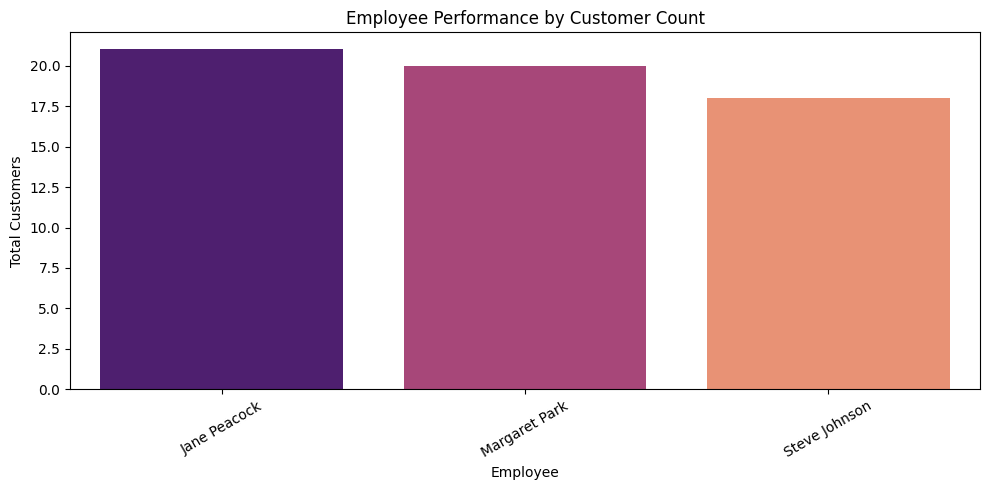

In [27]:
plt.figure(figsize=(10,5))
sns.barplot(data=employee_performace, x='employee_name', y='num_customers', palette='magma', hue='employee_name')
plt.title('Employee Performance by Customer Count')
plt.ylabel('Total Customers')
plt.xlabel('Employee')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

### Average Revenue trends by day of the week

Find trends about sales throughout the week by averaging data over a long period of time.

Visualise changes in revenue throughout the week.

In [32]:
day_of_week_revenue_query = """
SELECT 
    CASE strftime('%w', invoice.invoice_date)
        WHEN '0' THEN 'Sunday'
        WHEN '1' THEN 'Monday'
        WHEN '2' THEN 'Tuesday'
        WHEN '3' THEN 'Wednesday'
        WHEN '4' THEN 'Thursday'
        WHEN '5' THEN 'Friday'
        WHEN '6' THEN 'Saturday'
    END AS day_of_week,
    ROUND(AVG(total), 2) as avg_daily_gross_revenue
FROM invoice
GROUP BY CAST(strftime('%w', invoice_date) AS INTEGER)
ORDER BY CAST(strftime('%w', invoice_date) AS INTEGER);
"""
day_of_week_revenue = run_query(day_of_week_revenue_query)
print(day_of_week_revenue)

  day_of_week  avg_daily_gross_revenue
0      Sunday                     6.99
1      Monday                     7.85
2     Tuesday                     7.75
3   Wednesday                     7.71
4    Thursday                     7.18
5      Friday                     8.60
6    Saturday                     7.61


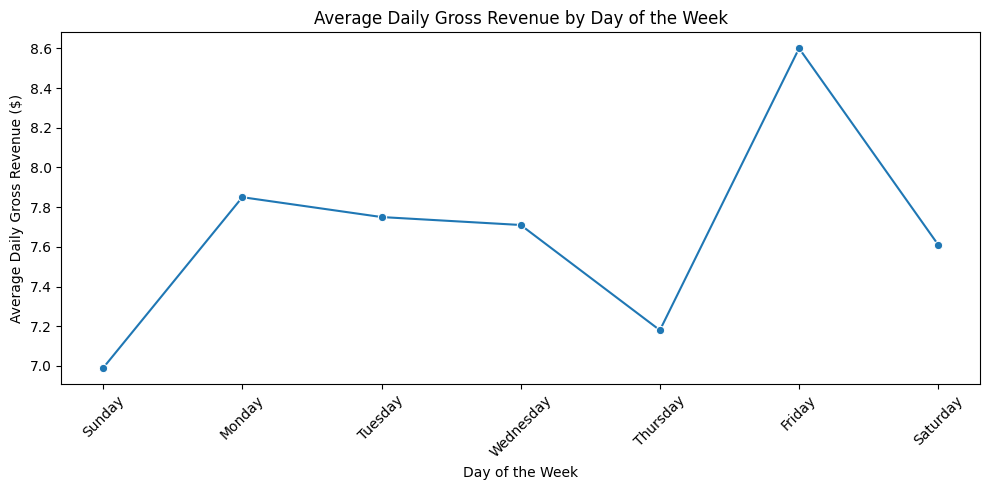

In [33]:
plt.figure(figsize=(10,5))
sns.lineplot(data=day_of_week_revenue, x='day_of_week', y='avg_daily_gross_revenue', marker='o')
plt.title('Average Daily Gross Revenue by Day of the Week')
plt.ylabel('Average Daily Gross Revenue ($)')
plt.xlabel('Day of the Week')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Customer Retention and Churn Analysis

This query tracks cohorts by their first purchase month and monitors how many customers remain active in subsequent months.

I think this query helps understand customer loyalty and churn over time, and would give great insight into possible areas of improvement and areas of success.

In [35]:
retention_churn_query = """
WITH first_purchase AS (
    SELECT customer_id, MIN(strftime('%Y-%m', invoice_date)) AS cohort_month
    FROM invoice
    GROUP BY customer_id
),
purchases AS (
    SELECT customer_id, strftime('%Y-%m', invoice_date) AS purchase_month
    FROM invoice
)
SELECT
    f.cohort_month,
    p.purchase_month,
    COUNT(DISTINCT p.customer_id) AS retained_customers,
    (CAST(substr(p.purchase_month, 1, 4) AS INTEGER) * 12 + CAST(substr(p.purchase_month, 6, 2) AS INTEGER)) -
    (CAST(substr(f.cohort_month, 1, 4) AS INTEGER) * 12 + CAST(substr(f.cohort_month, 6, 2) AS INTEGER)) AS months_since_first_purchase
FROM first_purchase f
JOIN purchases p ON f.customer_id = p.customer_id
GROUP BY f.cohort_month, p.purchase_month
ORDER BY f.cohort_month, p.purchase_month;
"""
retention_churn = run_query(retention_churn_query)
retention_churn.head()

,cohort_month,purchase_month,retained_customers,months_since_first_purchase
0,2017-01,2017-01,14,0
1,2017-01,2017-02,2,1
2,2017-01,2017-03,3,2
3,2017-01,2017-04,4,3
4,2017-01,2017-05,3,4


We can visualise the retention over time for a few recent cohorts.

In [42]:
# Calculate retention rate per cohort (active_customers / cohort size)
# Filter cohorts with at least 10 customers at month 0
cohort_sizes = retention_churn[retention_churn['months_since_first_purchase'] == 0].set_index('cohort_month')['retained_customers']
valid_cohorts = cohort_sizes[cohort_sizes >= 10].index
filtered_df = retention_churn[retention_churn['cohort_month'].isin(valid_cohorts)]

# Limit months to 24
filtered_df = filtered_df[filtered_df['months_since_first_purchase'] <= 24]

# Plot again with filtered_df instead of retention_df



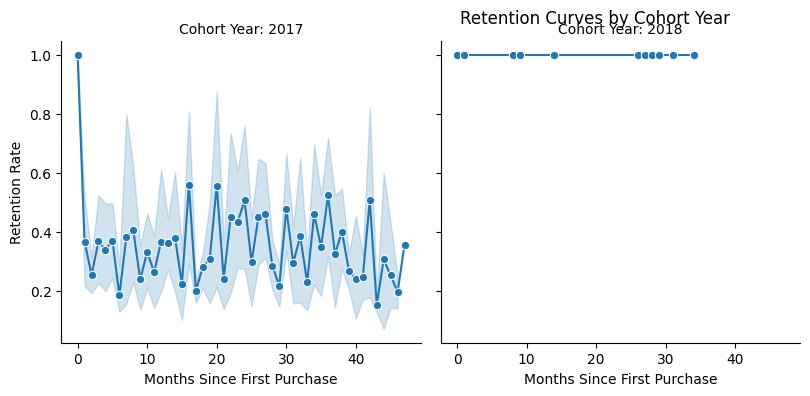

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

# Optionally, extract cohort year or quarter for faceting
retention_churn['cohort_year'] = retention_churn['cohort_month'].str[:4]

g = sns.FacetGrid(retention_churn, col='cohort_year', col_wrap=3, height=4, sharey=True)
g.map_dataframe(sns.lineplot, x='months_since_first_purchase', y='retention_rate', marker='o')

g.set_axis_labels("Months Since First Purchase", "Retention Rate")
g.set_titles("Cohort Year: {col_name}")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Retention Curves by Cohort Year')

plt.show()



While the dataset is limited past 2018 (as there are no customers making their first purchase past 2018), we can see that from the initial purchase in early 2017, over the course of 50 months, we have roughly a 40% retention rate.